In [1]:
%matplotlib inline

import cv2
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import os
import random

import doctest

## Margin 확인

In [2]:
def show_img_margin(img, row_margin, col_margin, fig=None, thick=2):
    """이미지에 마진 경계선을 그려넣어준다. 행(y):청색, 열(x):적색
    img -- numpy ndarray (0~255)
    row_margin -- (위쪽 마진, 아래쪽 마진) (pixel)
    col_margin -- (왼쪽 마진, 오른쪽 마진) (pixel) 
    """
    img_copy = np.copy(img)
    
    max_y, max_x, _ = img_copy.shape
    
    cv2.line(img_copy, (0, row_margin[0]), (max_x, row_margin[0]), (255, 0, 0), thick)
    cv2.line(img_copy, (0, max_y - row_margin[1]), (max_x, max_y - row_margin[1]), (255, 0, 0), thick)
    
    cv2.line(img_copy, (col_margin[0], 0), (col_margin[0], max_y), (0, 0, 255), thick)
    cv2.line(img_copy, (max_x - col_margin[1], 0), (max_x - col_margin[1], max_y), (0, 0, 255), thick)
    
    if fig is None:
        plt.figure(figsize=(8,8))
        
    plt.imshow(img_copy)
    
    return img_copy

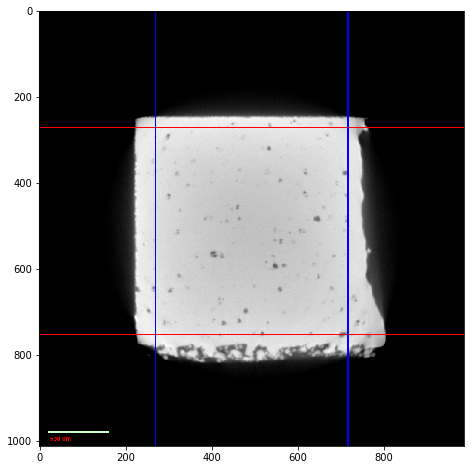

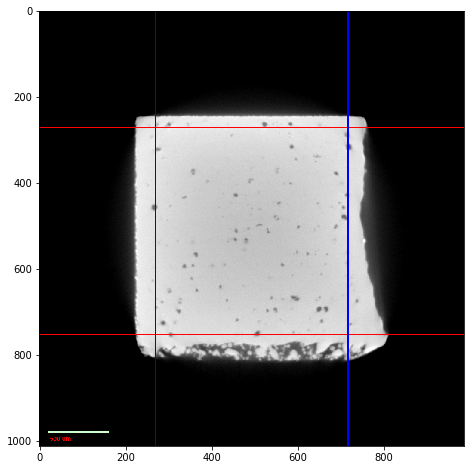

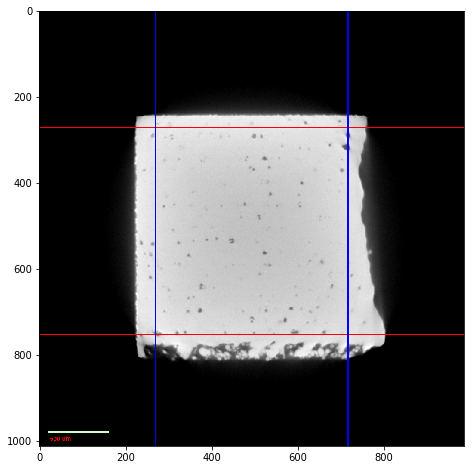

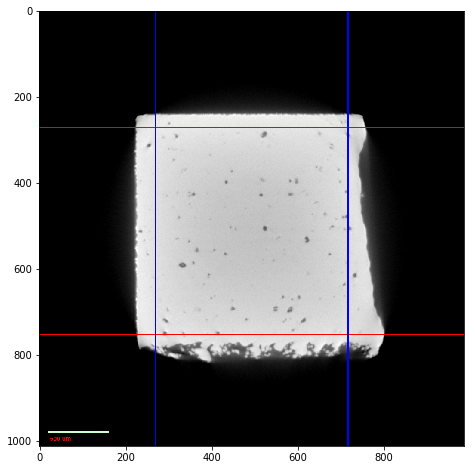

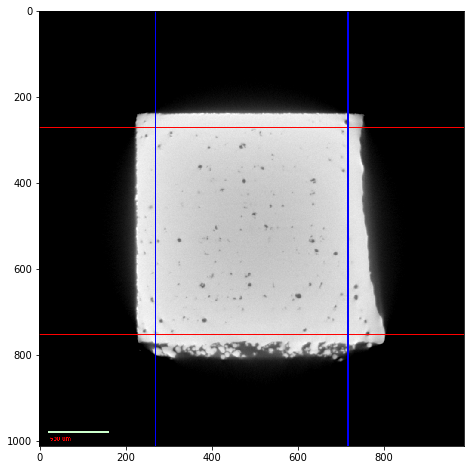

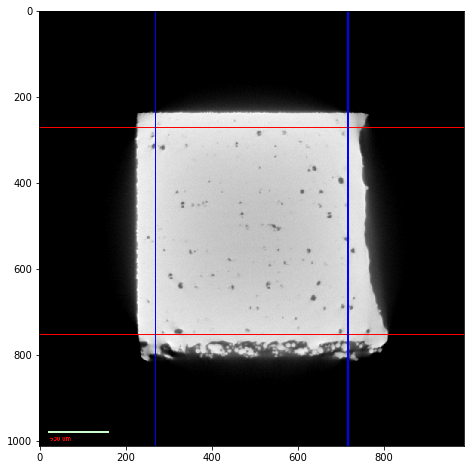

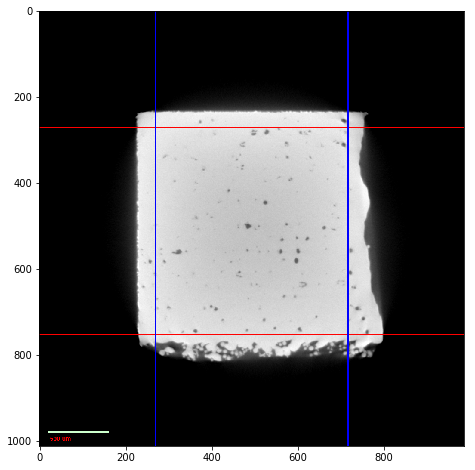

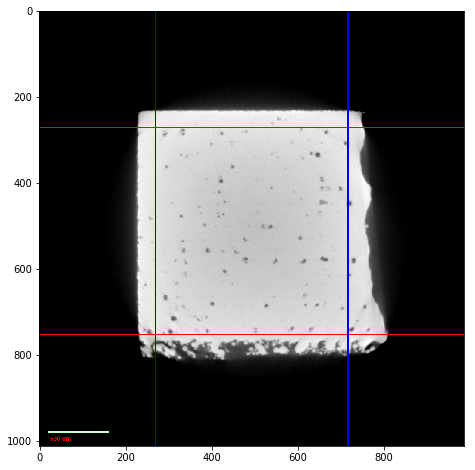

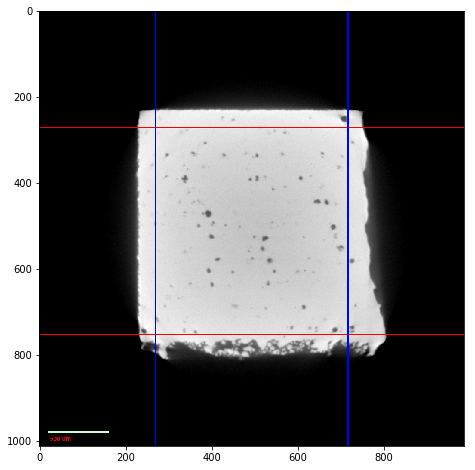

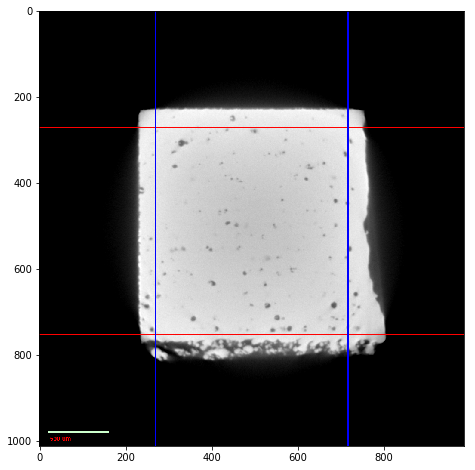

In [17]:
##
# 데이터 추출에서 제외할 가장자리 영역을 margin 값으로 지정하고, 이미지 상에서 확인해보자.
# 

data_dir = '/home/kikim/data/materials/xray_20180330/images/'
# dirs = [ '#1_CPTi_50W_300mm', '#4_CPTi_70W_700mm', '#3_CPti_70W_500mm', '#5_CPTi_90W_300mm', ]

class_dirs = {'short':['#4_CPTi_70W_700mm'], 
              'good':['#3_CPti_70W_500mm'], 
              'excessive':['#5_CPTi_90W_300mm'],}

# 수동으로;;; 찾은 폴더별 마진 값
dir_margins = { d:((250,250),(250,250)) for d in dirs }
dir_margins[class_dirs['short'][0]] = ((270,250),(260,250))
dir_margins[class_dirs['good'][0]] = ((270,250),(250,250))
dir_margins[class_dirs['excessive'][0]] = ((270,260),(270,270))

dir_filename_formats = {
    '#1_CPTi_50W_300mm':'#1_CPT_50W_300mm-sec_120kv_10W_Recon_B2_Export%04d.tif', 
    '#4_CPTi_70W_700mm':'#4_CPTi_70W_700mm-sec_120kV_10W_Recon_B2_Export%04d.tif',
    '#3_CPti_70W_500mm':'#3_CPTi_70W_500mm-sec_120kV_10W_Recon_B2_Export%04d.tif', 
    '#5_CPTi_90W_300mm':'#5_CPTi_90W_300mm-sec_120kV_10W_Recon_B2_Export%04d.tif', 
}

# 사진을 확인해보니, 1~49, 951~999는 경계 효과가 나타난다. 데이터로 사용 안하는 게 나을 듯.
file_nums = range(50, 1000, 100)

# 클래스 명을 바꿔가면서 마진 위치를 확인해보자.
for d in class_dirs['excessive']:
    for i in file_nums:
        file_name = dir_filename_formats[d] % i
        img = plt.imread(data_dir + d + '/' + file_name)
        show_img_margin(img, dir_margins[d][0], dir_margins[d][1])

    

## 256x256 작은 이미지 샘플링

(1011, 988, 3)



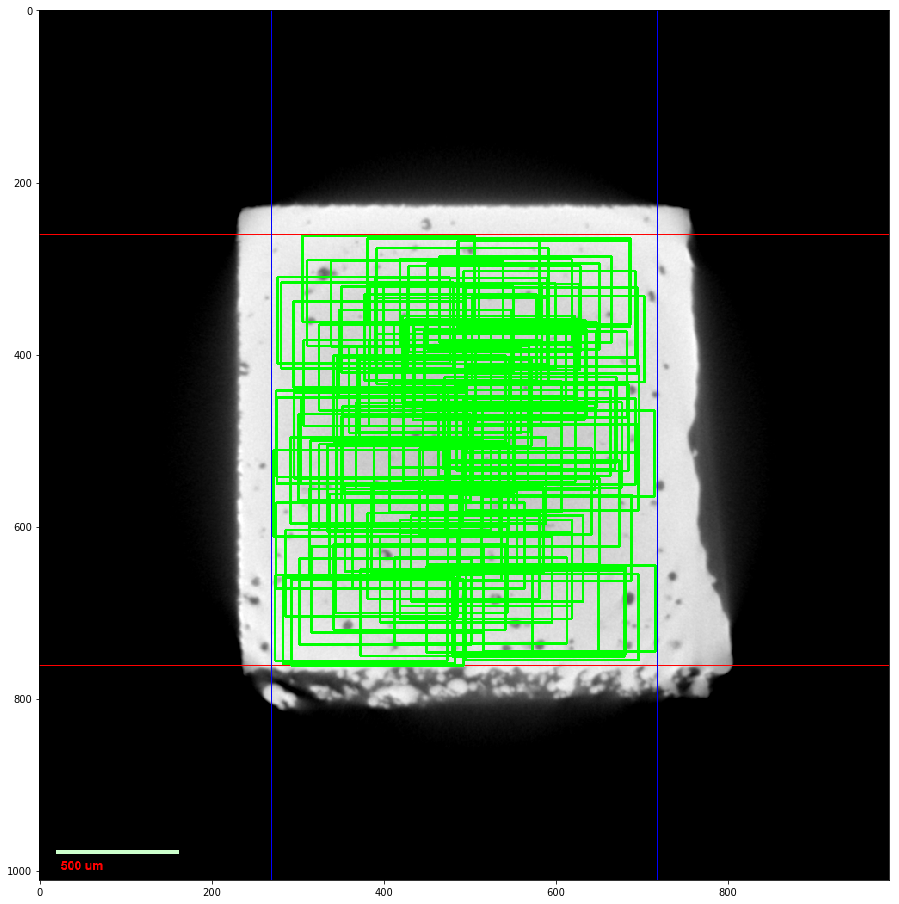

In [18]:
def sample_top_left(ori_shape, row_margin, col_margin, size):
    """유효 이미지 영역에서 원하는 크기의 영역을 랜덤 추출한다. return 값은 좌측 상단 좌표 (행(y), 열(x)).
    
    >>> sample_top_left([64, 32], (0, 0), (0, 0), [64, 32])
    (0, 0)
    
    >>> sample_top_left([64, 32], (16, 32), (8, 16), [16, 8])
    (16, 8)
    
    >>> 10 <= sample_top_left([64, 32], (10, 15), (5, 8), [16, 8])[0] <= 38
    True
    
    >>> 5 <= sample_top_left([64, 32], (10, 15), (5, 8), [16, 8])[1] <= 16
    True
    
    """
    col = random.randrange(col_margin[0], ori_shape[1] - col_margin[1] - size[1] + 1)
    row = random.randrange(row_margin[0], ori_shape[0] - row_margin[1] - size[0] + 1)
    
    return row, col
    
    
doctest.testmod()


# 범위 안에서 샘플링 되는지 단위테스트
for i in range(1000):
    y, x = sample_top_left([64, 32], (10, 15), (5, 8), [16, 8])
    assert 10 <= y <= 38
    assert 5 <= x <= 16
    
    
# 그려서 확인해보자.
size = [100, 200]
row_margin = (260,250)
col_margin = (270,270)

print(img.shape)
print()

fig = plt.figure(figsize=(16,16))
img_copy = show_img_margin(img, row_margin, col_margin, fig, 1)

for i in range(100):
    y, x = sample_top_left(img.shape, row_margin, col_margin, size)

#     print(x, y, x+size[1], y+size[0])

    cv2.rectangle(img_copy, (x, y), (x+size[1], y+size[0]), (0, 255, 0), 2)

    plt.imshow(img_copy)
    


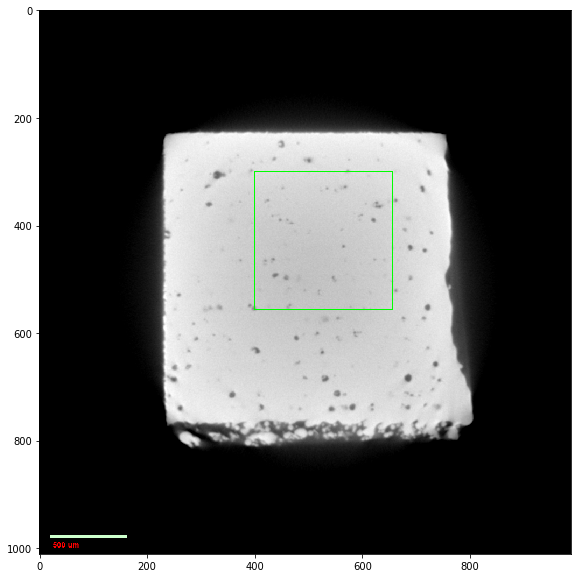

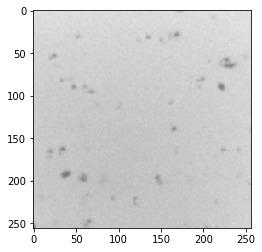

In [19]:
def cut_small_img(ori_img, top_left, size=(256,256)):
    """원본 이미지에서 일부를 잘라냄
    """
    
    small_img = np.zeros((size[0], size[1], ori_img.shape[2]), dtype=int)
    
    val = ori_img[top_left[0]:top_left[0]+size[0], top_left[1]:top_left[1]+size[1], :]
    
    small_img[max(0, -top_left[0]):min(size[0], ori_img.shape[0] - top_left[0]), 
              max(0, -top_left[1]):min(size[1], ori_img.shape[1] - top_left[1])] = val
    
    return small_img


size = [256, 256]
(y, x) = (300, 400)

fig = plt.figure(figsize=(10,10))
img_copy = np.copy(img)

cv2.rectangle(img_copy, (x, y), (x+size[1], y+size[0]), (0, 255, 0), 2)
plt.imshow(img_copy)

s_img = cut_small_img(img, (y, x), size)
fig = plt.figure()
plt.imshow(s_img)

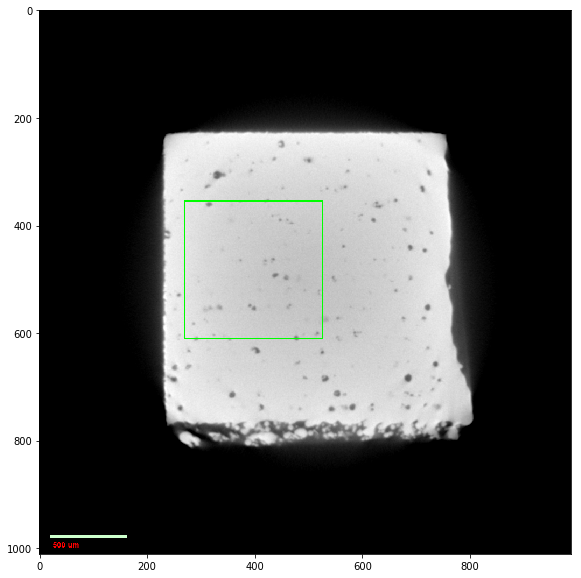

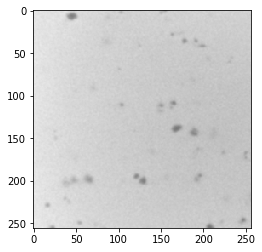

In [20]:
def sample_small_img(ori_img, margin_row=(250, 250), margin_col=(250, 250), size=(256, 256)):
    top_left = sample_top_left(ori_img.shape, margin_row, margin_col, size)
    
    small_img = cut_small_img(ori_img, top_left, size)
    
    return small_img, top_left


margins = dir_margins[class_dirs['excessive'][0]]
size = [256, 256]

s_img, (y, x) = sample_small_img(img, margins[0], margins[1], size)

fig = plt.figure(figsize=(10,10))
img_copy = np.copy(img)

cv2.rectangle(img_copy, (x, y), (x+size[1], y+size[0]), (0, 255, 0), 2)
plt.imshow(img_copy)

fig = plt.figure()
plt.imshow(s_img)

## Contrast / Brightness 조절

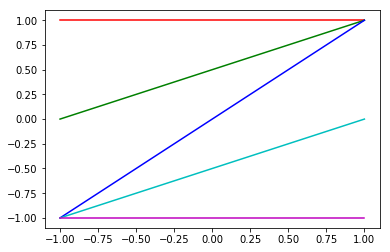

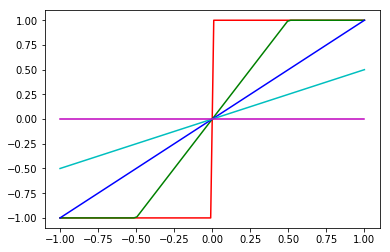

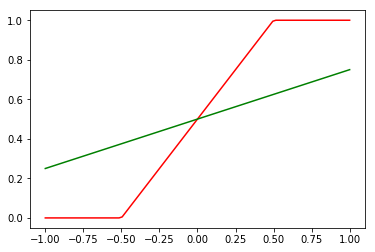

In [21]:
def transfer_fn_bright(x, b):
    y = 0.5 * ((1 - x) * (2 * max(b, 0) - 1) + (1 + x) * (2 * min(b, 0)+ 1))
        
    return y

def transfer_fn_contrast(x, c):
    if c >= 1:
        y = 2 * (x > 0) - 1
    elif c >= 0:
        y = x / (1 - c)
    else:
        y = x * (1 + c)
        
    y = np.clip(y, -1, 1)
    
    return y


x = np.linspace(-1, 1, 100)

plt.figure()
plt.plot(x, transfer_fn_bright(x, 1), '-r', 
         x, transfer_fn_bright(x, 0.5), '-g', 
         x, transfer_fn_bright(x, 0), '-b', 
         x, transfer_fn_bright(x, -0.5), '-c', 
         x, transfer_fn_bright(x, -1), '-m', 
        )

plt.figure()
plt.plot(x, transfer_fn_contrast(x, 1), '-r', 
         x, transfer_fn_contrast(x, 0.5), '-g', 
         x, transfer_fn_contrast(x, 0), '-b', 
         x, transfer_fn_contrast(x, -0.5), '-c', 
         x, transfer_fn_contrast(x, -1), '-m', 
        )


plt.figure()
plt.plot(x, transfer_fn_bright(transfer_fn_contrast(x, 0.5), 0.5), '-r', 
         x, transfer_fn_bright(transfer_fn_contrast(x, -0.5), 0.5), '-g', 
        )

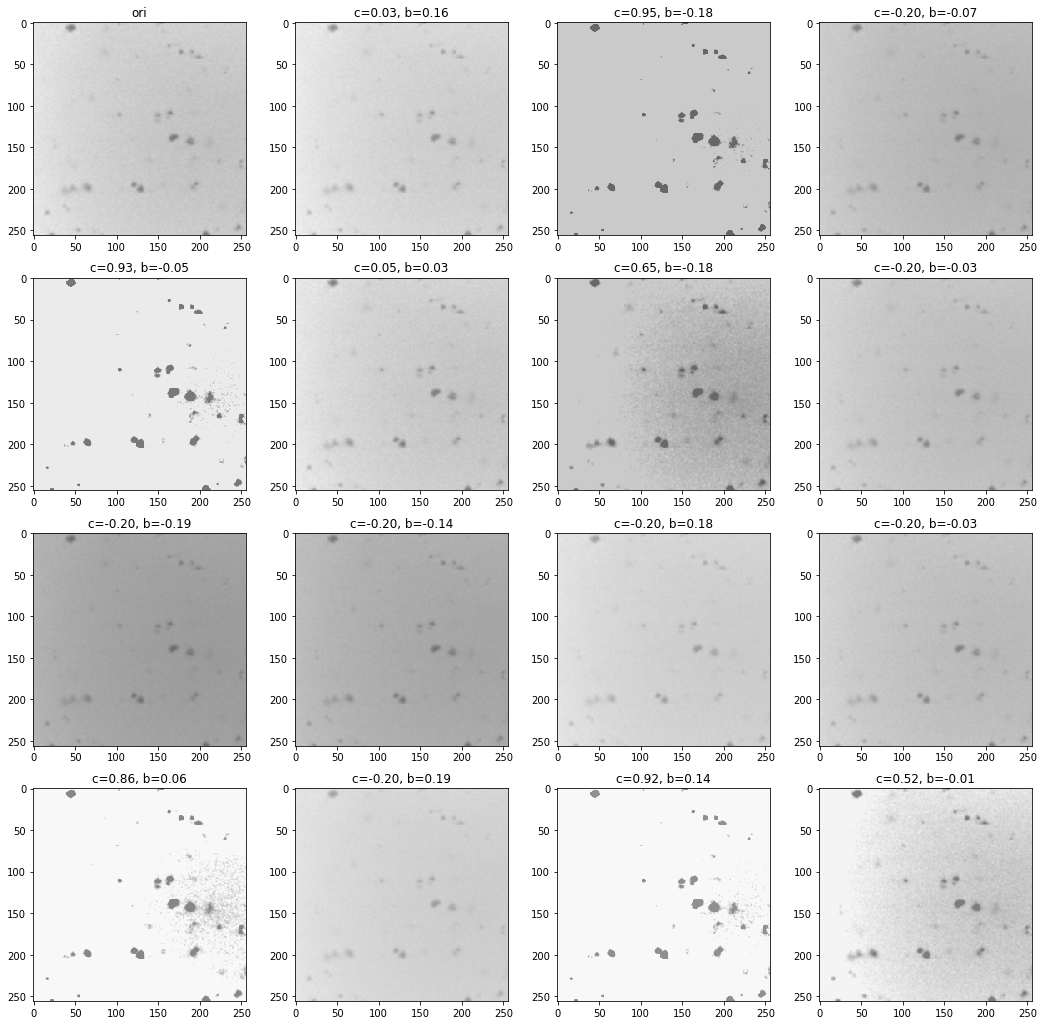

In [22]:
def modify_contrast_bright(img, contrast, brightness):
    """이미지의 contrast와 brightness 변경
    contrast: -1.0 ~ 1.0
    brightness: -1.0 ~ 1.0
    """
    
    x = (img - 127) / 128
    
    min_x = np.min(x)
    max_x = np.max(x)
    delta = (max_x - min_x) / 2
    
    if delta > 0:
        x = transfer_fn_contrast((x - delta) / delta, contrast) * delta + delta
    
    y = transfer_fn_bright(x, brightness)
    modified = np.uint8(128 * y + 127)
    
    return modified

row, col = (4, 4)

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(row, col, 1)
ax.set_title("ori")
ax.imshow(s_img)

for i in range(row * col - 1):
    ax = fig.add_subplot(row, col, 2 + i)
    c = max(-0.2, (np.random.random(1) - 0.5) * 2 * 1)
    b = (np.random.random(1) - 0.5) * 2 * 0.2
    ax.set_title("c=%.2f, b=%.2f" % (c,b))
    ax.imshow(modify_contrast_bright(s_img, c, b))


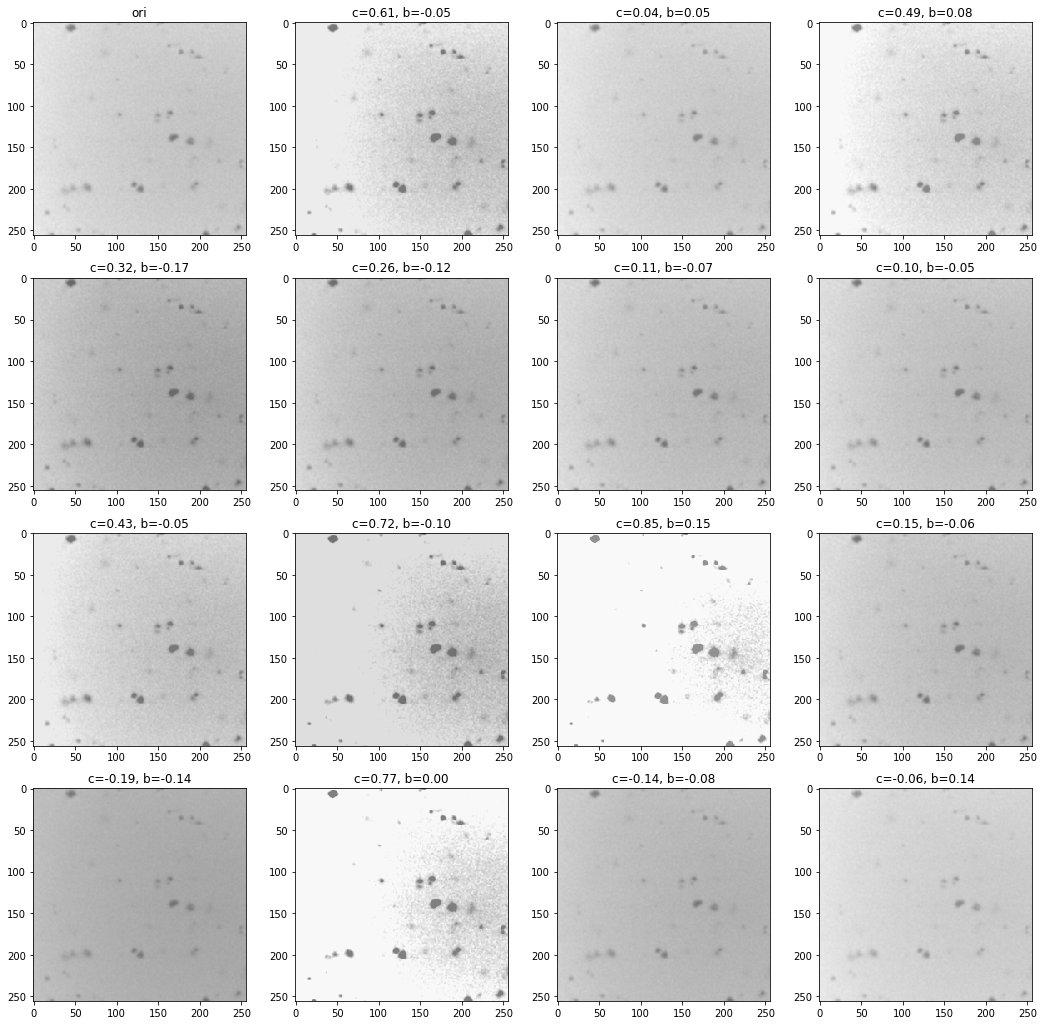

In [23]:
def modify_img(img, c_range, b_range):
    """이미지의 contrast와 brightness 를 랜덤하게 변경
    c_range: (min_contrast, max_contrast) (-1.0 ~ 1.0)
    b_range: (min_brightness, max_brightness) (-1.0 ~ 1.0)
    """
    
    c = np.random.random(1) * np.diff(c_range) + c_range[0]
    b = np.random.random(1) * np.diff(b_range) + b_range[0]
    
    return modify_contrast_bright(img, c, b), c, b


row, col = (4, 4)

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(row, col, 1)
ax.set_title("ori")
ax.imshow(s_img)

for i in range(row * col - 1):
    ax = fig.add_subplot(row, col, 2 + i)
    
    modified, c, b = modify_img(s_img, (-.2, 1), (-.2, .2))
    
    ax.set_title("c=%.2f, b=%.2f" % (c,b))
    ax.imshow(modified)

## Image Data 샘플링

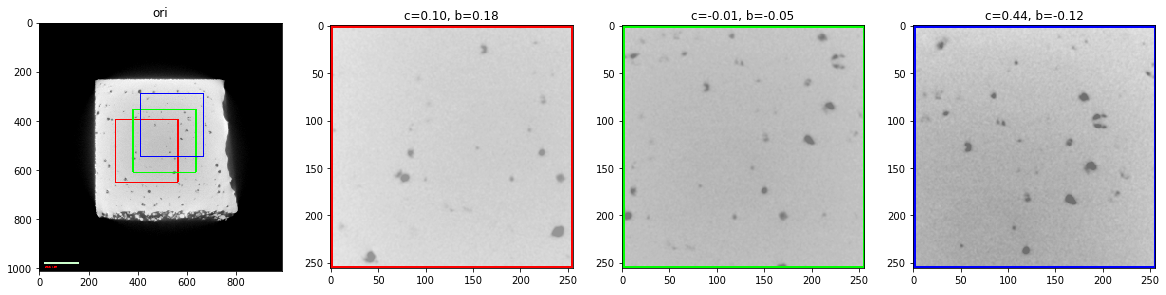

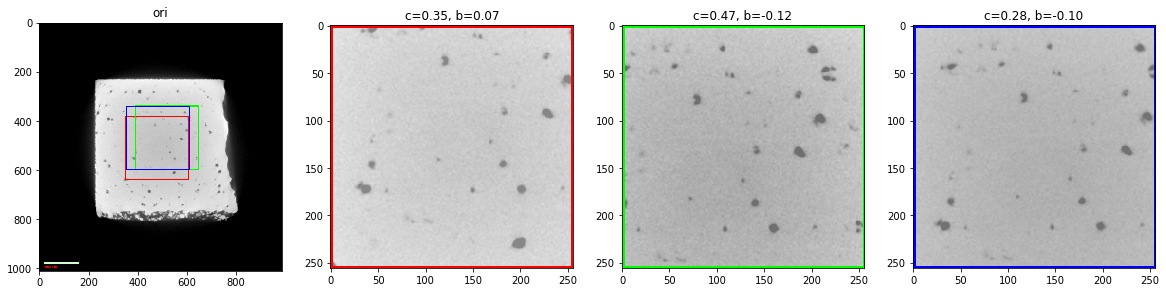

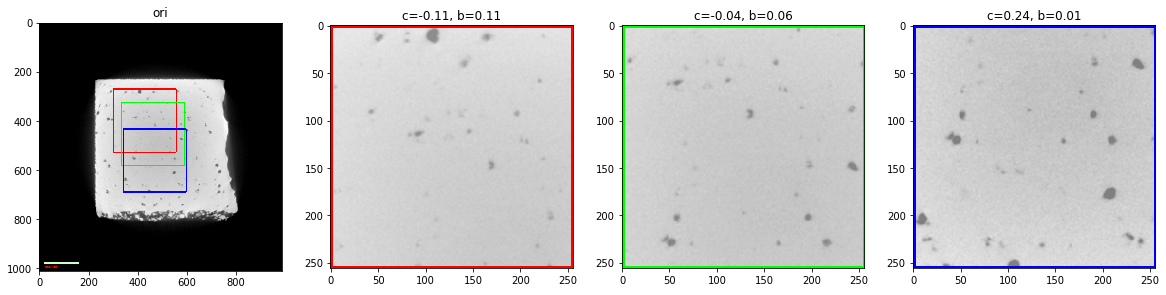

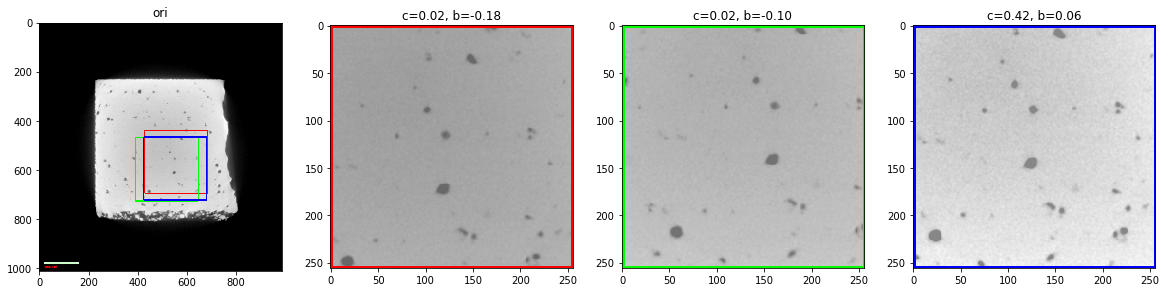

In [31]:
def sample_image(img, margin_row=(250, 250), margin_col=(250, 250), size=(256, 256), 
                 c_range=(-.2, .5), b_range=(-.2, .2)):
    
    s_img, top_left = sample_small_img(img, margin_row, margin_col, size)
    
    modified, c, b = modify_img(s_img, c_range, b_range)
    
    return modified, top_left, c, b


row, col = (1, 4)
# ax = fig.add_subplot(row, col, 1)
# ax.set_title("ori")
# ax.imshow(img)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), ]

for n in range(4):
    fig = plt.figure(figsize=(20, 5))
    ori_img = np.copy(img)

    for i in range(row * col - 1):
        ax = fig.add_subplot(row, col, 2 + i)

        modified, (y, x), c, b = sample_image(img, margins[0], margins[1])
        cv2.rectangle(modified, (0, 0), (256,256), colors[i], 3)
        
        ax.set_title("c=%.2f, b=%.2f" % (c,b))
        ax.imshow(modified)

        cv2.rectangle(ori_img, (x, y), (x+size[1], y+size[0]), colors[i], 4)
    
    ax = fig.add_subplot(row, col, 1)
    ax.set_title("ori")
    ax.imshow(ori_img)

In [28]:
start_time = datetime.datetime.now()
print(start_time)
print(class_dirs)

dir_dataset = '/home/kikim/data/materials/xray_20180330/dataset_%s/' % datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print('path to save: ', dir_dataset)

img_name_format = '%05d.jpg'

# 1~999 의 파일들 중에서 어느 범위를 사용할 지 정의
dataset_filenum_range = {'train':(50, 450), 'valid':(450, 650), 'test':(650, 950)}

# mkdir
for dataset_name in dataset_filenum_range.keys():
    for class_name in class_dirs.keys():
        pathlib.Path(os.path.join(dir_dataset, dataset_name, class_name)).mkdir(parents=True, exist_ok=True)

# 데이터셋 별 개수
dataset_N = {'train':10000, 'valid':2000, 'test':3000}

for (dataset_name, filenum_range) in dataset_filenum_range.items():
    N = dataset_N[dataset_name]
    
    for (class_name, dirs) in class_dirs.items():
        file_nums = np.random.randint(filenum_range[0], filenum_range[1], size=N)
        
        for (i, n) in enumerate(file_nums):
            d = np.random.choice(dirs)
            file_name = dir_filename_formats[d] % n
            read_file_path = os.path.join(data_dir + d, file_name)
            
            img = plt.imread(read_file_path)
            
            margins = dir_margins[d]
            sampled, _, _, _ = sample_image(img, margins[0], margins[1])
            
            save_file_path = os.path.join(dir_dataset, dataset_name, class_name, img_name_format % i)
            
            cv2.imwrite(save_file_path, sampled)
            
            
elapsed_time = datetime.datetime.now() - start_time
print('Elapsed time:', elapsed_time)

2018-05-11 21:24:04.595225
{'short': ['#4_CPTi_70W_700mm'], 'good': ['#3_CPti_70W_500mm'], 'excessive': ['#5_CPTi_90W_300mm']}
path to save:  /home/kikim/data/materials/xray_20180330/dataset_20180511_212404/
Elapsed time: 0:08:04.646853
